# Категоризация топ слов для каждой темы

In [63]:
import pandas as pd
import numpy as np

from tqdm import tqdm as tq

import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
topics_df = pd.read_csv('squares_topics.csv', sep='\t')

In [67]:
topics_df.head()

,square_contain_id,top5,latitude,longitude
0,56384,"(['спб', 'маникюр', 'ноготь', 'озерко', 'ресни...",60.041502,30.325467
1,56455,"(['спб', 'волос', 'ресница', 'наращивание', 'к...",60.041223,30.389278
2,57010,"(['акро', 'спорт', 'гимнастика', 'акробатика',...",60.040760,30.315360
3,57750,"(['маникюр', 'гельлак', 'шеллак', 'спб', 'граж...",60.040585,30.407930
4,57800,"(['спб', 'кухня', 'ремонт', 'торт', 'дизайн', ...",60.040426,30.453263


In [68]:
topics_df.top5 = topics_df.top5.map(eval)

Получим все отдельные темы

In [69]:
all_topics = []
topics_df.top5.apply(lambda x: all_topics.extend(x))
None

### Кластеризация

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(map(lambda x: " ".join(x), all_topics)))

In [10]:
from sklearn.manifold import TSNE

decompositor = TSNE()
transformed_X = decompositor.fit_transform(X)

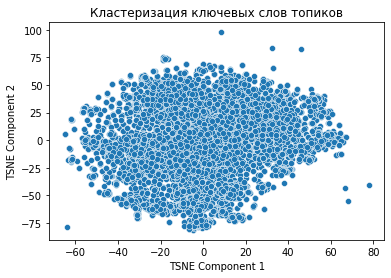

In [11]:
plt.title('Кластеризация ключевых слов топиков')

sns.scatterplot(
    x=transformed_X[:, 0],
    y=transformed_X[:, 1],
)

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()

### Тематическое моделирование

Попробуем разделить на темы и посмотреть когерентность

In [70]:
from gensim.models import nmf, LdaModel, LsiModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [71]:
common_dictionary = Dictionary(all_topics)
common_corpus = [common_dictionary.doc2bow(text) for text in all_topics]

In [179]:
def find_optimal_topics_for_model(Model, n_topics=range(2, 30)):
    """
    Проходимся по количествам тем и подсчитываем когерентность.
    """

    scores = []
    models = []


    for t in tq(n_topics):
        model = Model(common_corpus, num_topics=t, id2word=common_dictionary)
        cm = CoherenceModel(model=model, corpus=common_corpus, coherence='u_mass')
        coherence = cm.get_coherence()

        models.append(model)
        scores.append(coherence)
        
    plt.title('{} topics vs coherence'.format(Model.__name__))
    plt.plot(n_topics, scores)

    plt.xlabel('n_topics')
    plt.ylabel('coherence')
    
    plt.show()
    
    return scores, models[scores.index(max(scores))]

100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


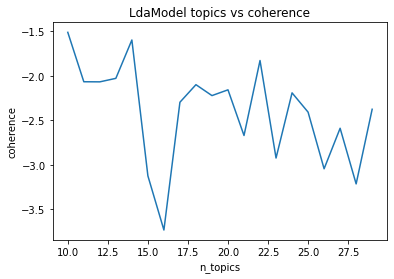

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


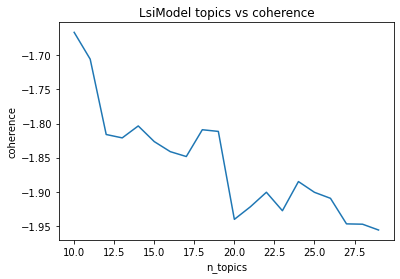

100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


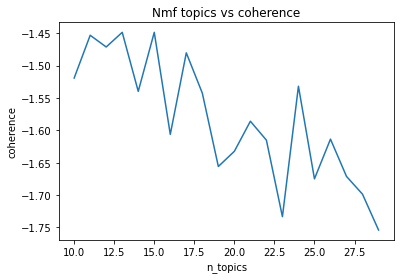

In [96]:
lda_scores, lda_optim_model = find_optimal_topics_for_model(LdaModel)
lis_scores, lsi_optim_model = find_optimal_topics_for_model(LsiModel)
nmf_scores, nmf_optim_model = find_optimal_topics_for_model(nmf.Nmf)

In [181]:
len(lda_scores)

28

In [182]:
len(lis_scores)

28

In [183]:
len(nmf_scores)

28

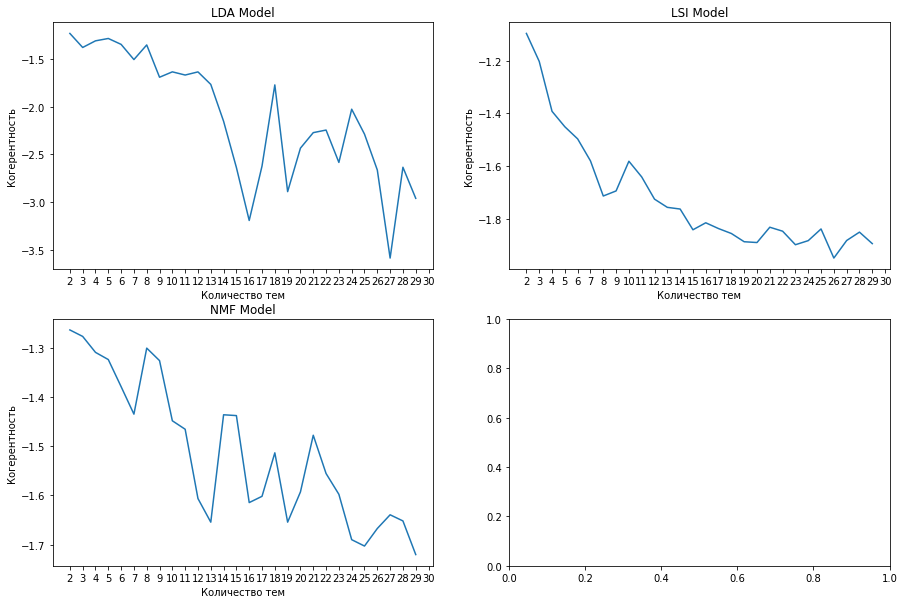

In [209]:
fg, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (scores, label) in enumerate(zip([lda_scores, lis_scores, nmf_scores], ['LDA Model', 'LSI Model', 'NMF Model'])):
    axes.flat[i].title.set_text(label)
    axes.flat[i].plot(range(2, 30), scores)
    axes.flat[i].set(ylabel='Когерентность', xlabel='Количество тем', xticks=range(2, 31))

### Визуализация тем LDA

In [18]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [19]:
vis = pyLDAvis.gensim.prepare(lda_optim_model, common_corpus, dictionary=lda_optim_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.089230  0.061157       1        1  19.166443
10    -0.013683  0.069494       2        1  16.050213
5      0.051356 -0.011718       3        1  11.466837
8      0.044825  0.142922       4        1  10.298731
6      0.122360  0.106176       5        1   9.651764
11     0.173781 -0.096854       6        1   8.030188
3      0.122737 -0.090273       7        1   7.024256
9     -0.146938 -0.026614       8        1   5.400639
4     -0.097833  0.083679       9        1   5.104953
0      0.131114 -0.009791      10        1   3.359317
7     -0.225255 -0.028760      11        1   3.064692
2     -0.073235 -0.199416      12        1   1.381974, topic_info=             Term         Freq        Total Category  logprob  loglift
1           волос  1727.000000  1727.000000  Default  30.0000  30.0000
11        маникюр  1470.000000  1470.000000  Default  29.0000  29.0000
71    окрашивание   996.000000   996.000000  Default  28.0000  28.0000
1228    ленинский   476.000000   476.000000  Default  27.0000  27.0000
15         ноготь  1252.000000  1252.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
29           свой    17.631573  3344.383057  Topic12  -5.2196  -0.9637
60     фотосессия    14.297633   480.565887  Topic12  -5.4292   0.7668
24         работа    14.825671  2997.944336  Topic12  -5.3929  -1.0277
8        красивый    14.021492  1594.439331  Topic12  -5.4487  -0.4520
5          запись    13.836341  2077.158203  Topic12  -5.4620  -0.7298

[909 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
4783     12  0.804346      агентство
327       4  0.059514  администратор
327       7  0.029757  администратор
327       8  0.892707  администратор
1766      5  0.082128    акварельный
...     ...       ...            ...
698       3  0.888810          ягода
698       4  0.052283          ягода
698       6  0.052283          ягода
2097      8  0.874144         якутия
3813     11  0.862999        ёлочный

[3480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 6, 9, 7, 12, 4, 10, 5, 1, 8, 3])

### Подбор тем

Все одинаково плохи :(.

Давайте попробуем найти лучшую модель для пяти тем 

In [90]:
def fit_model_for_n_topic(Model, n_topic):
    model = Model(common_corpus, num_topics=n_topic, id2word=common_dictionary)
    cm = CoherenceModel(model=model, corpus=common_corpus, coherence='u_mass')
    coherence = cm.get_coherence()

    print(Model.__name__)
    print('Coherence:', coherence)
    
    return model

In [187]:
# lda_5_topics_model = fit_model_for_n_topic(LdaModel, 8)
# lsi_5_topics_model = fit_model_for_n_topic(LsiModel, 8)
nmf_5_topics_model = fit_model_for_n_topic(nmf.Nmf, 9)

Nmf
Coherence: -1.4548268138349543


In [186]:
nmf_optim_model

In [128]:
nmf_5_topics_model.save('nmf_8')

NMF справился лучше всего

In [188]:
import gensim
import numpy as np

all_topics_csr = gensim.matutils.corpus2csc(nmf_optim_model.get_document_topics(common_corpus))
all_topics_numpy = all_topics_csr.T.toarray()

In [189]:
keywords_topics_df = pd.DataFrame()
keywords_topics_df['top_words'] = all_topics
keywords_topics_df['topic_id'] = np.argmax(all_topics_numpy, axis=1)

In [191]:
for i in range(9):
    print(i, ", ".join(list(map(lambda x: x[0], nmf_optim_model.show_topic(i, 50)))), '\n')

0 свой, делать, работа, хороший, кожа, спб, самый, процедура, волос, лицо, новый, красота, сделать, уход, большой, тело, бровь, мастер, окрашивание, запись, любить, массаж, цвет, эффект, знать, результат, питер, маска, косметика, фото, масло, средство, друг, любой, губа, подарок, ботокс, работать, глаз, крем, ресница, косметолог, красивый, макияж, стрижка, дом, состав, использовать, стать, вода 

1 спб, питер, заказ, директ, цена, доставка, новый, маникюр, профиль, дизайн, одежда, цвет, писать, ноготь, размер, запись, фото, платье, подарок, петербург, работа, красивый, руб, ссылка, шапка, мастер, наращивание, педикюр, красота, наличие, свой, любой, купить, гельлак, москва, магазин, стиль, гвоздь, россия, хороший, модель, ресница, мода, макияж, проспект, покрытие, скидка, вопрос, дом, санкт 



IndexError: index 2 is out of bounds for axis 1 with size 2

In [131]:
topics_names = {
    0: 'Одежда',
    1: 'Маникюр',
    2: 'Услуги красоты',
    3: 'Услуги фотостудий',
    4: 'Дизайн квартир/домов',
    5: 'Фитнес',
    6: 'Салоны красоты',
    7: 'Доставка товаров',
}

In [139]:
keywords_topics_df['topic_name'] = keywords_topics_df['topic_id'].apply(topics_names.get)

In [155]:
keywords_topics_df['label'] = keywords_topics_df.top_words.str[:5].str.join(' ')

In [156]:
keywords_topics_df

,top_words,topic_id,topic_name,label
0,"[спб, маникюр, ноготь, озерко, ресница, волос,...",6,Салоны красоты,спб маникюр ноготь озерко ресница
1,"[спб, волос, ресница, наращивание, кожа, красо...",5,Фитнес,спб волос ресница наращивание кожа
2,"[спб, маникюр, платье, ноготь, красота, дизайн...",1,Маникюр,спб маникюр платье ноготь красота
3,"[спб, свой, ресторан, цвет, подарок, питер, ма...",7,Доставка товаров,спб свой ресторан цвет подарок
4,"[акро, спорт, гимнастика, акробатика, фитнес, ...",7,Доставка товаров,акро спорт гимнастика акробатика фитнес
...,...,...,...,...
6726,"[шоурум, наличие, распродажа, женский, одежда,...",0,Одежда,шоурум наличие распродажа женский одежда
6727,"[спб, новорождённый, фотограф, фотосессия, фот...",4,Дизайн квартир/домов,спб новорождённый фотограф фотосессия фото
6728,"[одежда, ребёнок, выписка, спб, мама, малыш, д...",0,Одежда,одежда ребёнок выписка спб мама
6729,"[бортик, кроватка, грызунок, держатель, спб, п...",4,Дизайн квартир/домов,бортик кроватка грызунок держатель спб


In [157]:
keywords_topics_df[['label', 'topic_name']].to_csv('keywords_topics_df.csv', sep='\t', index=False)

In [166]:
keywords_topics_df[keywords_topics_df.label.str.contains('ламинирование')]

,top_words,topic_id,topic_name,label
250,"[шугаринг, процедура, депиляция, ботокс, ламин...",6,Салоны красоты,шугаринг процедура депиляция ботокс ламинирование
665,"[бровь, спб, окрашивание, коррекция, ламиниров...",6,Салоны красоты,бровь спб окрашивание коррекция ламинирование
749,"[бровь, спб, макияж, ламинирование, татуаж, ок...",3,Услуги фотостудий,бровь спб макияж ламинирование татуаж
1262,"[спб, волос, процедура, цвет, ламинированиерес...",6,Салоны красоты,спб волос процедура цвет ламинированиересница
1287,"[бровь, бестужевский, ламинирование, балл, про...",6,Салоны красоты,бровь бестужевский ламинирование балл процедура
1859,"[работа, спб, волос, процедура, ламинирование,...",6,Салоны красоты,работа спб волос процедура ламинирование
3854,"[бровь, еда, рецепт, ламинирование, свой, вкус...",6,Салоны красоты,бровь еда рецепт ламинирование свой
4015,"[спб, бровь, волос, окрашивание, ламинирование...",2,Услуги красоты,спб бровь волос окрашивание ламинирование
4480,"[бровь, спб, процедура, ламинирование, укладка...",6,Салоны красоты,бровь спб процедура ламинирование укладка
4610,"[бровь, спб, окрашивание, ламинирование, татуа...",6,Салоны красоты,бровь спб окрашивание ламинирование татуаж


In [142]:
topics_model = nmf_5_topics_model

Для каждого квадрата запишем его тему

In [143]:
len(all_topics)

6731

In [144]:
topics_topics = []

for el in topics_model.get_document_topics(common_corpus):
    topics_topics.append([topics_names[el[i][0]] for i in range(len(el)) if el[i][1] > 0.2])

In [145]:
squares = []

for row in topics_df.iloc:
    squares.extend([row['square_contain_id']] * len(row['top5']))

In [146]:
df = pd.DataFrame({
    'square_contain_id': squares,
    'keywords': all_topics,
    'topic': topics_topics
})

In [147]:
df = df.merge(topics_df, on='square_contain_id').drop('top5', axis=1)

In [148]:
df.head()

,square_contain_id,keywords,topic,latitude,longitude
0,56384,"[спб, маникюр, ноготь, озерко, ресница, волос,...","[Маникюр, Салоны красоты]",60.041502,30.325467
1,56455,"[спб, волос, ресница, наращивание, кожа, красо...",[Фитнес],60.041223,30.389278
2,56455,"[спб, маникюр, платье, ноготь, красота, дизайн...","[Маникюр, Услуги красоты, Услуги фотостудий]",60.041223,30.389278
3,56455,"[спб, свой, ресторан, цвет, подарок, питер, ма...","[Услуги фотостудий, Салоны красоты, Доставка т...",60.041223,30.389278
4,57010,"[акро, спорт, гимнастика, акробатика, фитнес, ...","[Дизайн квартир/домов, Доставка товаров]",60.040760,30.315360


In [149]:
df.to_csv('topics_coordinates.csv', sep='\t', index=False)